In [3]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')

In [4]:
from langchain_groq.chat_models import ChatGroq
llm=ChatGroq(model="openai/gpt-oss-120b")

In [5]:
llm

ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 32768, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': True, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x000001B9D53F68A0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001B9D5053140>, model_name='openai/gpt-oss-120b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [9]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(
    model='sentence-transformers/all-MiniLM-L6-v2'
)

Loading weights: 100%|██████████| 103/103 [00:00<00:00, 524.47it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [11]:
import bs4
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing_extensions import  List,TypedDict

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [14]:
loader=WebBaseLoader(
    web_path="https://lilianweng.github.io/posts/2024-04-12-diffusion-video/",
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-title", "post-content")
        )
    )
)
docs=loader.load()

In [15]:
docs

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2024-04-12-diffusion-video/'}, page_content='\n      Diffusion Models for Video Generation\n    Diffusion models have demonstrated strong results on image synthesis in past years. Now the research community has started working on a harder task—using it for video generation. The task itself is a superset of the image case, since an image is a video of 1 frame, and it is much more challenging because:\n\nIt has extra requirements on temporal consistency across frames in time, which naturally demands more world knowledge to be encoded into the model.\nIn comparison to text or images, it is more difficult to collect large amounts of high-quality, high-dimensional video data, let along text-video pairs.\n\n\n\n🥑 Required Pre-read: Please make sure you have read the previous blog on “What are Diffusion Models?” for image generation before continue here.\n\n\nVideo Generation Modeling from Scratch#\nFirst let’s review approache

In [17]:
text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    
)

In [18]:
all_split=text_splitter.split_documents(docs)

In [22]:
all_split

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2024-04-12-diffusion-video/'}, page_content='Diffusion Models for Video Generation\n    Diffusion models have demonstrated strong results on image synthesis in past years. Now the research community has started working on a harder task—using it for video generation. The task itself is a superset of the image case, since an image is a video of 1 frame, and it is much more challenging because:\n\nIt has extra requirements on temporal consistency across frames in time, which naturally demands more world knowledge to be encoded into the model.\nIn comparison to text or images, it is more difficult to collect large amounts of high-quality, high-dimensional video data, let along text-video pairs.\n\n\n\n🥑 Required Pre-read: Please make sure you have read the previous blog on “What are Diffusion Models?” for image generation before continue here.'),
 Document(metadata={'source': 'https://lilianweng.github.io/posts/2024-04-12-di

In [27]:
from langchain_community.vectorstores import FAISS
vectorstore=FAISS.from_documents(
    all_split,
    embeddings
)

In [28]:
vectorstore

In [31]:
from langchain.tools import tool

In [33]:
@tool
def retriever(query:str)->str:
    """Retriever the information related to the query"""
    retrieved_docs=vectorstore.similarity_search(query,k=2)
    serialized_docs="\n\n".join([doc.page_content for doc in retrieved_docs])
    return serialized_docs

In [36]:
from langchain_core.messages import BaseMessage,SystemMessage,AIMessage
from langgraph.checkpoint.memory  import MemorySaver
from langgraph.graph import END,START,StateGraph,MessagesState
from langgraph.prebuilt import ToolNode,tools_condition

In [37]:
def query_or_respond(state:MessagesState):
    """Generate tool call for retrievel or response"""
    llm_with_tools=llm.bind([retriever])
    response=llm_with_tools.invoke(state['messages'])
    return {"messages":[response]}

In [40]:
#Executing the retriever
tools=ToolNode([retriever])
tools

tools(tags=None, recurse=True, explode_args=False, func_accepts={'config': ('N/A', <class 'inspect._empty'>), 'runtime': ('N/A', <class 'inspect._empty'>)}, _tools_by_name={'retriever': StructuredTool(name='retriever', description='Retriever the information related to the query', args_schema=<class 'langchain_core.utils.pydantic.retriever'>, func=<function retriever at 0x000001B99FCBA980>)}, _injected_args={'retriever': _InjectedArgs(state={}, store=None, runtime=None)}, _handle_tool_errors=<function _default_handle_tool_errors at 0x000001B98551E2A0>, _messages_key='messages', _wrap_tool_call=None, _awrap_tool_call=None)

In [42]:
#Making the geneate node in here
def generate(state:MessagesState):
    """Generate the answer"""
    recent_tool_messages=[]
    for message in state.messages:
        if message.type=="human":
            recent_tool_messages.append(message)
        elif message.type=="ai":
            recent_tool_messages.append(message)
        elif message.type=="tool":
            recent_tool_messages.append(message)

    tool_messages=recent_tool_messages[-3:]

    #Format into the prompt

    docs_content="\n\n".join(docs.content for docs in tool_messages)
    system_messages_content=(
        "You are a helpful assistant that can answer questions about the library."
        'Use the follwing pieces of information to answer the question.\n\n'
        "the questions  if you dont know the answer say that you"
    )
    conversation_messages=[
        message
        for message in state.messages
        if message.type in {"human","ai"}
    ]
    prompt=[SystemMessages(system_messages_content)]+conversation_messages
    response=llm.invoke(prompt)
    return {"messages":[response]}
    
    

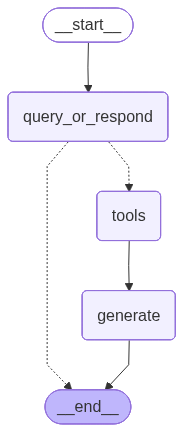

In [43]:
graph=StateGraph(MessagesState)
graph.add_node(query_or_respond)
graph.add_node(tools)
graph.add_node(generate)
graph.set_entry_point('query_or_respond')
graph.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END:END,"tools":"tools"},
)
graph.add_edge("tools","generate")
graph.add_edge("generate",END)
graph.compile()

In [44]:
graph

In [45]:
memory=MemorySaver()
graph_builder=graph.compile(checkpointer=memory)

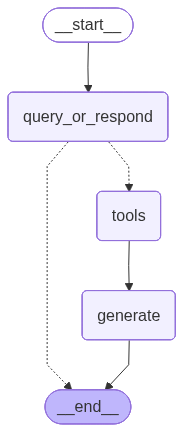

In [46]:
graph_builder

In [48]:
from langgraph.prebuilt import create_react_agent
agent_executor=create_react_agent(llm,[retriever],checkpointer=memory)

C:\Users\PARAS\AppData\Local\Temp\ipykernel_8932\994579627.py:2: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  agent_executor=create_react_agent(llm,[retriever],checkpointer=memory)


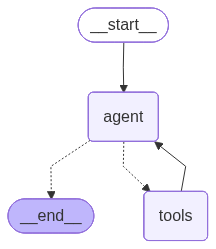

In [49]:
agent_executor